Что можно взять для того, чтобы распознавать токены как аспекты?
1. Мы говорили о CRF и подобных
2. Мы говорили о разных нейронках -- преимущественно свёртки и рекуррентные
3. Нам нужно будет работать с текстом

Исходя из этого и погуглив тьюториалы на пайторче, решено было использовать сочетание LSTM и CRF, с надеждой на то, что на наших маленьких примерах эта модель с небольшим количеством эпох не успеет сильно переобучиться

И кажется, нам удалось. Качество на тесте, конечно, ниже, чем на трейне -- однако мы выделяем почти все метки, что нужны

Что мы брали для обучения и зачем. Что -- train_split из проекта. Что мы с ним делали:
1. Взяли ревью и аспекты
2. Разметили ревью леммами, стартом и эндом (есть варианты сто станзой и с ручной разметкой, в ручной что-то сбивается)
3. По старту и энду мы нашли для каждого токена, является ли он каким-нибудь аспектом, и если да, то каким
4. Последовательность лемм предложения и последовательность тегов аспектов предложения подаётся в модель
5. С тестом делается та же предобработка
6. Последовательности лемм предложений теста подаются в модель
7. Модель отдаёт последовательность тегов аспектов
8. Каждому токену в датафрейме отдаём его аспект
9. С помощью Dostoevsky предсказываем тональность
10. На основании предсказанного собираем тональность по категориям отзыва
11. Сравниваемся с эталоном

Что получилось:
1. Моделька хорошая. Берём случайное предложение, вообще никакого отношения к корпусу не имеющее. Смотрим, как хорошо.
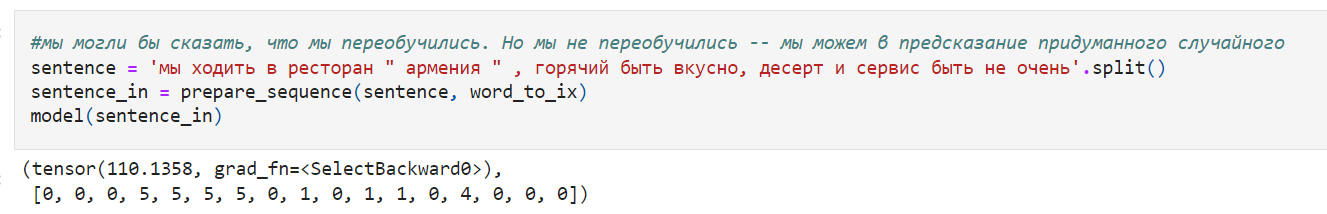

5 -- это место, 1 -- еда, 4 -- сервис. Всё как положно